In [46]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
%run modified_gibbs.ipynb

In [3]:
macro2_csv = pd.read_excel('./data/macro2.xlsx')
macro2_csv.head()

,gdpsh465,bmp1l,freeop,freetar,h65,hm65,hf65,p65,pm65,pf65,...,syr65,syrm65,syrf65,teapri65,teasec65,ex1,im1,xr65,tot1,Outcome
0,6.591674,0.2837,0.153491,0.043888,0.007,0.013,0.001,0.29,0.37,0.21,...,0.033,0.057,0.010,47.6,17.3,0.0729,0.0667,0.348,-0.014727,-0.024336
1,6.829794,0.6141,0.313509,0.061827,0.019,0.032,0.007,0.91,1.00,0.65,...,0.173,0.274,0.067,57.1,18.0,0.0940,0.1438,0.525,0.005750,0.100473
2,8.895082,0.0000,0.204244,0.009186,0.260,0.325,0.201,1.00,1.00,1.00,...,2.573,2.478,2.667,26.5,20.7,0.1741,0.1750,1.082,-0.010040,0.067051
3,7.565275,0.1997,0.248714,0.036270,0.061,0.070,0.051,1.00,1.00,1.00,...,0.438,0.453,0.424,27.8,22.7,0.1265,0.1496,6.625,-0.002195,0.064089
4,7.162397,0.1740,0.299252,0.037367,0.017,0.027,0.007,0.82,0.85,0.81,...,0.257,0.287,0.229,34.5,17.6,0.1211,0.1308,2.500,0.003283,0.027930


In [33]:
X = macro2_csv.drop(columns=['Outcome']).values.astype(np.float64)
y = macro2_csv['Outcome'].values.astype(np.float64)

scaler = StandardScaler()
X = scaler.fit_transform(X)
y = scaler.fit_transform(y.reshape(-1, 1)).reshape(len(y))

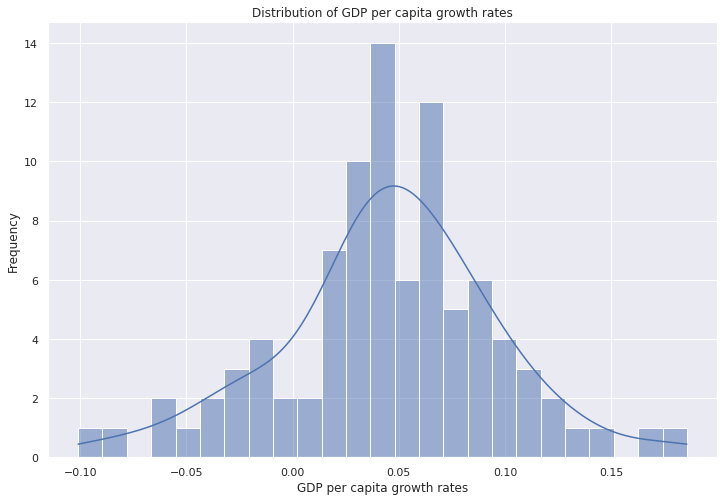

In [12]:
sns.set_style("darkgrid")
plt.figure(figsize=(12, 8))
sns.histplot(macro2_csv['Outcome'], kde=True, bins=25)
plt.title('Distribution of GDP per capita growth rates')
plt.xlabel('GDP per capita growth rates')
plt.ylabel('Frequency')
plt.savefig("./figures/gdp_hist.png")
plt.show()

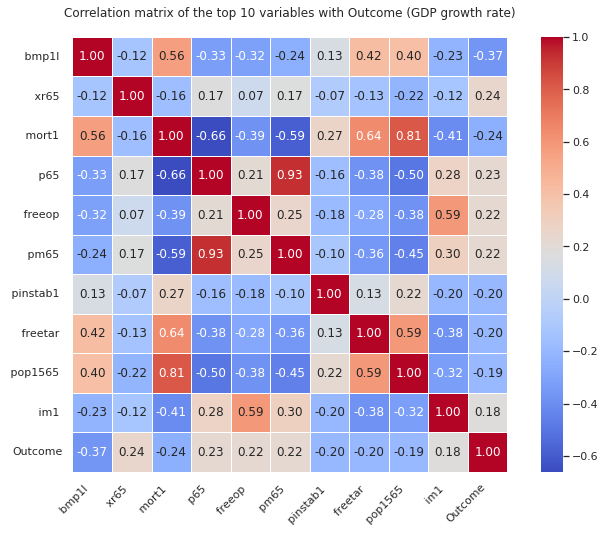

In [13]:
correlation_matrix = macro2_csv.corr()
correlation_with_outcome = correlation_matrix['Outcome']
top_10_correlated = correlation_with_outcome.abs().sort_values(ascending=False)[1:11]
top_10_variables = top_10_correlated.index.tolist() + ['Outcome']
top_10_corr_matrix = macro2_csv[top_10_variables].corr()
plt.figure(figsize=(12, 8))
sns.set(style="white")

heatmap = sns.heatmap(top_10_corr_matrix, annot=True, fmt=".2f", cmap="coolwarm",

                      cbar=True, square=True, linewidths=.5, annot_kws={"size": 12})

heatmap.set_title('Correlation matrix of the top 10 variables with Outcome (GDP growth rate)', pad=20)

plt.xticks(rotation=45, ha="right")

plt.yticks(rotation=0)
plt.savefig("./figures/correlation_plot.png")
plt.show()


## Linear regression (LASSO)

In [34]:
X = macro2_csv.drop('Outcome', axis=1)
y = np.array(macro2_csv['Outcome'])
alpha_range = np.arange(0.1, 1, 0.01) # we prepare the alpha range of hyperparameters for Lasso
 
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', Lasso())  
])

grid_search = GridSearchCV(pipeline, {'lasso__alpha': alpha_range}, cv=10, scoring='neg_mean_squared_error')

grid_search.fit(X, y)

best_alpha = grid_search.best_params_['lasso__alpha']
best_mse = -grid_search.best_score_
best_rmse = np.sqrt(best_mse)

# We fit the best Lasso model
best_lasso_model = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', Lasso(alpha=best_alpha))
])

scaler = StandardScaler()

y = scaler.fit_transform(y.reshape(-1, 1))

best_lasso_model.fit(X, y)

y_pred_best = best_lasso_model.predict(X)

y_pred_best = scaler.inverse_transform(y_pred_best.reshape(-1, 1))
y = scaler.inverse_transform(y.reshape(-1, 1))

# Considering only the non-zero coefficients
non_zero_coefs = best_lasso_model.named_steps['lasso'].coef_ != 0
coef_df = pd.DataFrame({
    'Feature': X.columns[non_zero_coefs],
    'Coefficient': best_lasso_model.named_steps['lasso'].coef_[non_zero_coefs]
})

best_alpha, best_rmse, coef_df.head(10)

(0.1,
 0.05268068271822814,
       Feature  Coefficient
 0      bmp1l     -0.235015
 1       hf65     -0.087844
 2       pm65      0.089138
 3    geerec1     -0.100049
 4       gde1      0.093968
 5   pinstab1     -0.076516
 6    seccm65      0.014322
 7   teapri65      0.001560
 8   teasec65      0.009038
 9        im1      0.034648)

In [19]:
# top coefficients 

abs_coefs = np.abs(best_lasso_model.named_steps['lasso'].coef_)
feature_names = X.columns

feature_coefs = pd.DataFrame({'Feature': feature_names, 'Absolute coefficient': abs_coefs})

sorted_features = feature_coefs.sort_values(by='Absolute coefficient', ascending=False)

top_5_least_shrunk = sorted_features.head(5)

top_5_least_shrunk

,Feature,Absolute coefficient
1,bmp1l,0.235015
59,xr65,0.102819
21,geerec1,0.100049
22,gde1,0.093968
8,pm65,0.089138


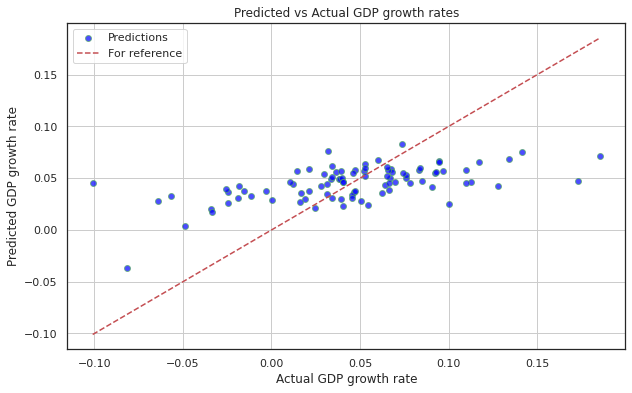

In [20]:
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred_best, alpha=0.7, label='Predictions', color='blue', edgecolor='g')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='For reference')
plt.xlabel('Actual GDP growth rate')
plt.ylabel('Predicted GDP growth rate')
plt.title('Predicted vs Actual GDP growth rates')
plt.legend()
plt.grid(True)
plt.show()

## Bayesian analysis

In [21]:
l = 0
T = len(macro2_csv)
k = len(macro2_csv.columns) - 1 
a, b, A, B = 1, 1, 1, 1
Ry_vals = [0.02, 0.25, 0.5]
s_vals = [5, 10, 25]

In [9]:
q_medians_list, q_sample_list, beta_list, sigma_squared_list = gibbs_sampling_parallel(X, y, s_range=s_vals, Ry_range=Ry_vals, T=T, k=k, rho=0.75, n_iter=10000, burn_in=1000, save_to="tests") # 6 s / per pairs (s, Ry) for 10 * 50 = 500 iterations

(s, Ry) = (5, 0.02)
(s, Ry) = (5, 0.25)
(s, Ry) = (5, 0.5)
(s, Ry) = (10, 0.02)
(s, Ry) = (10, 0.25)
(s, Ry) = (25, 0.02)
(s, Ry) = (25, 0.25)
(s, Ry) = (10, 0.5)
Dataset no. 0. Elapsed Time 474.4952964782715
(s, Ry) = (25, 0.5)
Dataset no. 0. Elapsed Time 475.2936553955078
Dataset no. 0. Elapsed Time 483.122309923172
Dataset no. 0. Elapsed Time 484.6030762195587
Dataset no. 0. Elapsed Time 485.3145229816437
Dataset no. 0. Elapsed Time 485.8454866409302
Dataset no. 0. Elapsed Time 487.09429144859314
Dataset no. 0. Elapsed Time 488.93501234054565
Dataset no. 0. Elapsed Time 142.68138718605042


In [32]:
def calculate_rmse(Y, X, beta_mean):
    """Calculate RMSE using the mean beta coefficients."""
    Y_pred = X @ beta_mean
    rmse = np.sqrt(mean_squared_error(Y, Y_pred))
    return rmse

model_metrics = []


# Find best s, Ry
for Ry in Ry_vals:
    for s in s_vals:
        beta_file = f"./tests/result_beta_s_{s}_Ry_{Ry}_dataset0.csv"
        if os.path.exists(beta_file):
            beta_df = pd.read_csv(beta_file)
            beta_mean = beta_df.mean().values
            rmse = calculate_rmse(y, X, beta_mean)
            model_metrics.append({'Ry': Ry, 's': s, 'RMSE': rmse})

# Convert to DataFrame for easier comparison
metrics_df = pd.DataFrame(model_metrics)
print(metrics_df)

     Ry   s      RMSE
0  0.02   5  0.674200
1  0.02  10  0.676515
2  0.02  25  0.678877
3  0.25   5  0.674594
4  0.25  10  0.678131
5  0.25  25  0.677175
6  0.50   5  0.677847
7  0.50  10  0.673668
8  0.50  25  0.677660


In [36]:
def load_y_pred_samples(s, Ry):
    """Load y_pred_samples given s and Ry"""
    path = f"./tests/result_y_pred_s_{s}_Ry_{Ry}_dataset0.csv"
    return pd.read_csv(path).values

def calculate_rmse(Y_actual, Y_pred_mean):
    """Calculate the RMSE for a set of predictions"""
    return np.sqrt(mean_squared_error(Y_actual, Y_pred_mean))

The best parameters are : s=25, Ry=0.02, RMSE=0.025359614049258135


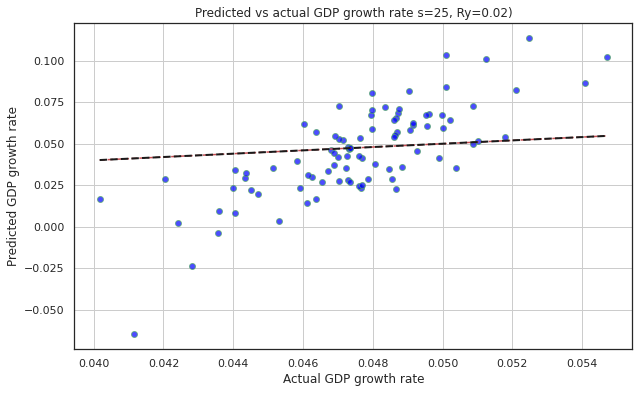

In [53]:
# Load the actual GDP growth rate (Y)
Y_actual = scaler.inverse_transform(y.reshape(-1, 1))

# Compare models
best_rmse = float('inf')
best_model = None
best_y_pred_mean = None



for s in s_vals:
    for Ry in Ry_vals:
        Y_pred_samples = load_y_pred_samples(s, Ry)
        Y_pred_samples = scaler.inverse_transform(Y_pred_samples)
        Y_pred_mean = Y_pred_samples.mean(axis=0)
        rmse = calculate_rmse(Y_actual, Y_pred_mean)
        if rmse < best_rmse:
            best_rmse = rmse
            best_model = (s, Ry)
            best_y_pred_mean = Y_pred_mean

print(f"The best parameters are : s={best_model[0]}, Ry={best_model[1]}, RMSE={best_rmse}")

plt.figure(figsize=(10, 6))
plt.scatter(Y_actual, best_y_pred_mean, alpha=0.7, label='Predictions', color='blue', edgecolors='g')
plt.plot([Y_actual.min(), Y_actual.max()], [Y_actual.min(), Y_actual.max()], 'r--', label='For reference')
plt.grid(True)
plt.xlabel('Actual GDP growth rate')
plt.ylabel('Predicted GDP growth rate')
plt.title(f'Predicted vs actual GDP growth rate s={best_model[0]}, Ry={best_model[1]})')
plt.plot([Y_actual.min(), Y_actual.max()], [Y_actual.min(), Y_actual.max()], 'k--', lw=2)  # This is for reference
plt.savefig("./figures/bayesian_regression.png")
plt.show()

s = 25, Ry = 0.02

In [40]:
# Compute posterior probabilities of inclusion for the "best" betas

beta_file_path = './tests/result_beta_s_25_Ry_0.02_dataset0.csv'
beta_data = pd.read_csv(beta_file_path, header=None)

posterior_prob_inclusion = (beta_data != 0).mean()

mean_betas = beta_data.mean()


column_names = macro2_csv.columns[:-1]  # except Outcome

beta_df = pd.DataFrame({
    'Covariate': column_names,
    'Beta Coefficient': mean_betas,
    'Posterior Probability of Inclusion': posterior_prob_inclusion
})

sorted_beta_df = beta_df.sort_values(by='Posterior Probability of Inclusion', ascending=False)
sorted_beta_df.reset_index(drop=True, inplace=True)
sorted_beta_df[sorted_beta_df["Posterior Probability of Inclusion"] >= 0.5]

,Covariate,Beta Coefficient,Posterior Probability of Inclusion
0,bmp1l,-0.263745,0.993667
1,gdpsh465,-0.310981,0.907556
2,gde1,0.178438,0.882556
3,p65,0.209641,0.741889
4,geerec1,-0.131672,0.722778
5,pinstab1,-0.092191,0.699778
6,seccm65,0.145259,0.662111
7,mort1,-0.162911,0.651778
8,hf65,-0.128056,0.647778
9,pm65,0.111907,0.627778
